# Práctica 2. Clustering de semillas

## 1. Visualización de datos con distintos scalers + PCA

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


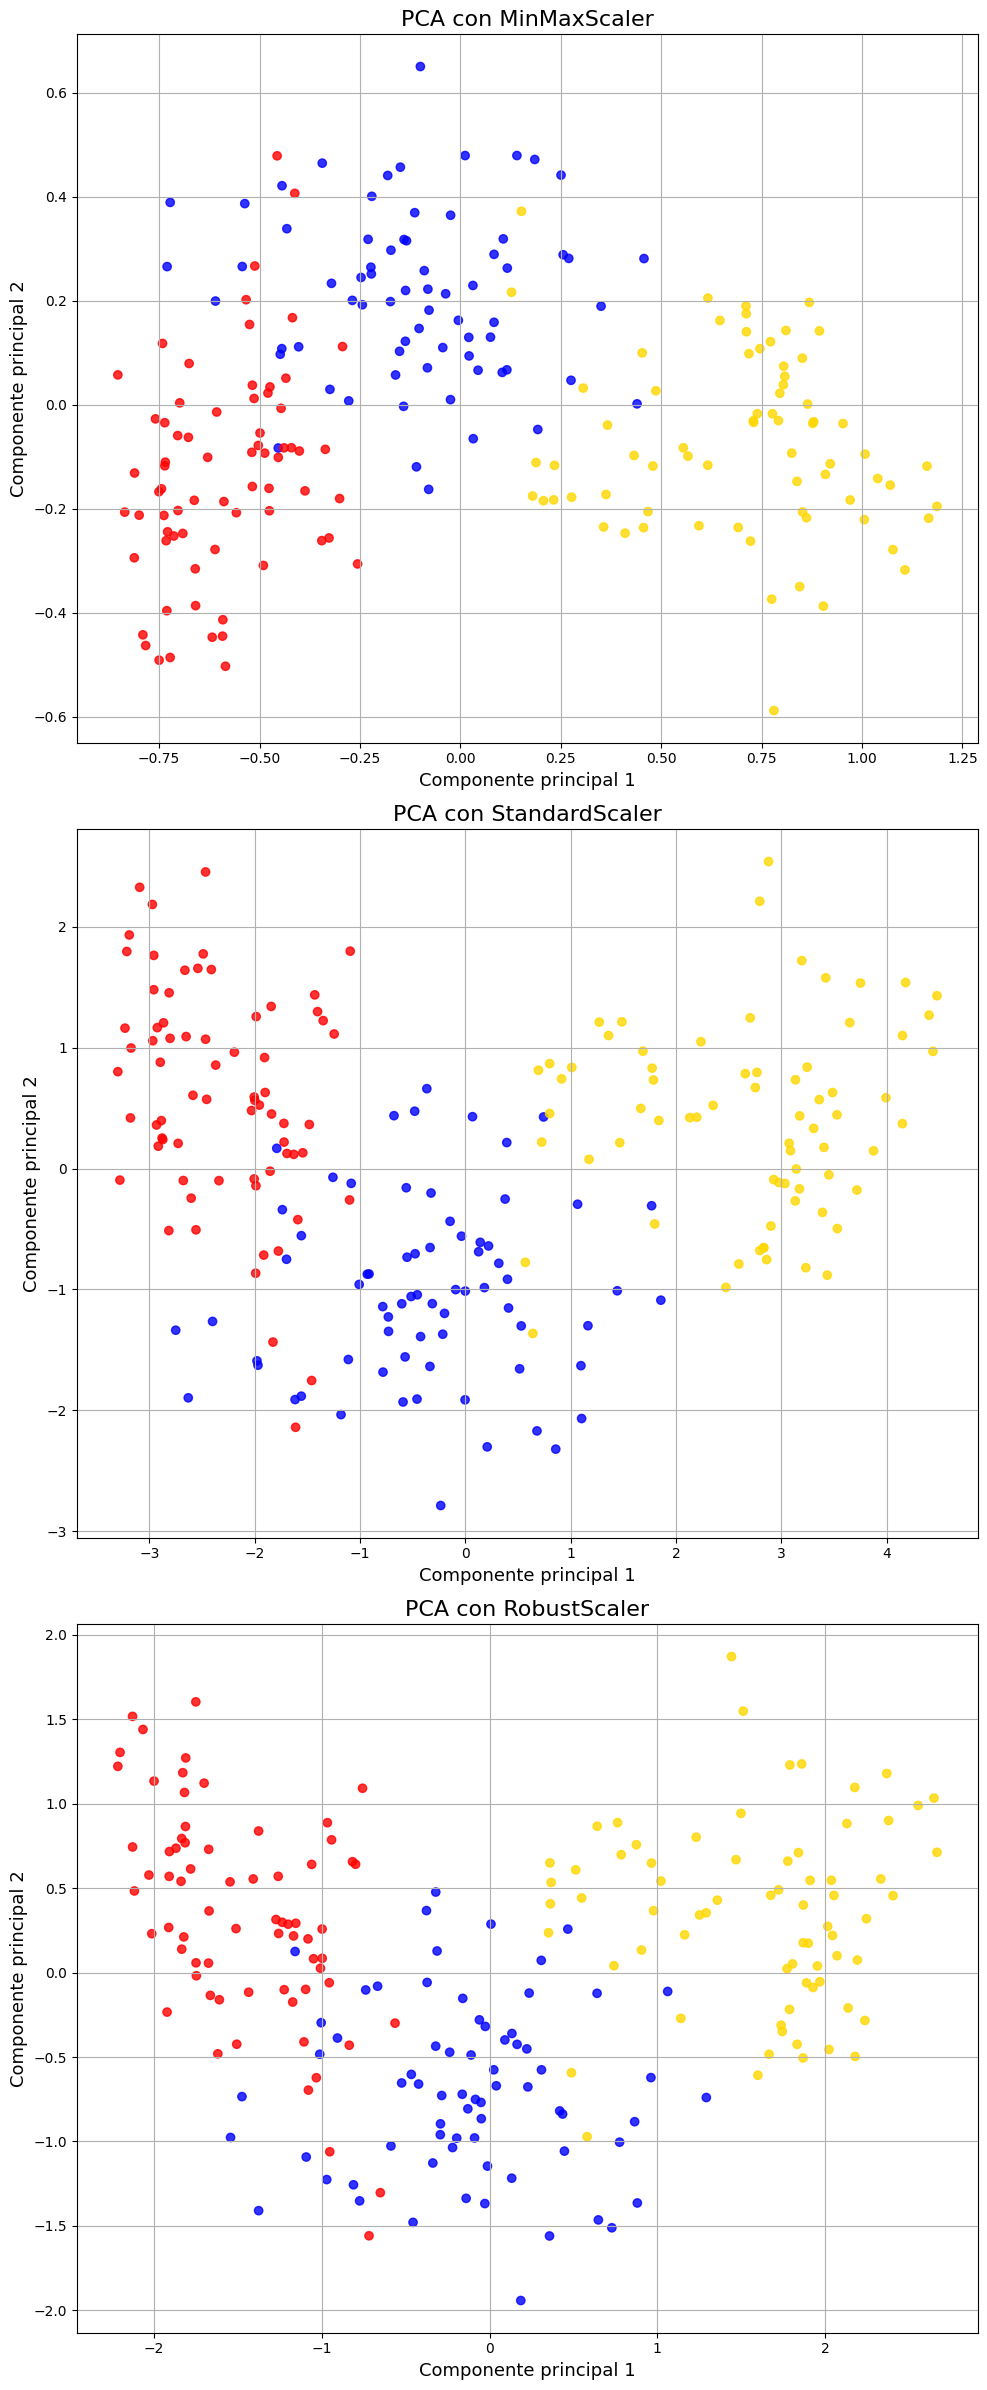

In [26]:
# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Mapeo de colores personalizados por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Definir los escaladores
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Crear figura para mostrar los 3 gráficos verticalmente
fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # 10 de ancho, 24 de alto

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):
    pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_pca = pipeline.fit_transform(X)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8)
    ax.set_title(f"PCA con {scaler_name}", fontsize=16)
    ax.set_xlabel("Componente principal 1", fontsize=13)
    ax.set_ylabel("Componente principal 2", fontsize=13)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Comparativa de escaladores tras PCA 

Se ha aplicado PCA a los datos de semillas tras escalar con tres métodos distintos: **MinMaxScaler**, **StandardScaler** y **RobustScaler**. En cada caso se proyectan las instancias sobre los dos primeros componentes principales.

Los puntos están coloreados según la clase real de semilla:
- 🔵 Clase 1
- 🟡 Clase 2
- 🔴 Clase 3

#### Observaciones:
- **MinMaxScaler** ofrece una separación aceptable, especialmente entre las clases 2 (amarillo) y 3 (rojo), aunque con algo más de solapamiento en el centro.
- **StandardScaler** proporciona una separación **muy clara entre las tres clases**, con fronteras bastante definidas entre cada grupo. Las clases se distribuyen mejor en el plano de componentes.
- **RobustScaler** también consigue una separación razonable, aunque los grupos no se distinguen tanto como con StandardScaler. Aun así, es robusto ante valores extremos.

#### Conclusión:
**StandardScaler** es el método de escalado que mejor preserva la estructura de clases del conjunto de datos original, facilitando una posible tarea de clustering. Por ello, se utilizará como preprocesamiento base en los siguientes apartados.


## 2. Técnicas de Clustering
Usamos X_2d aplicar los algoritmos de clustering: KMeans, jerárquico y DBSCAN, y visualizar los resultados de los clusters en un gráfico bidimensional

In [27]:
# Separar características (sin la clase)
X = df.iloc[:, :-1]

# Aplicar escalado y reducción a 2 dimensiones
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

### Método del codo y silhoutte (KMeans)

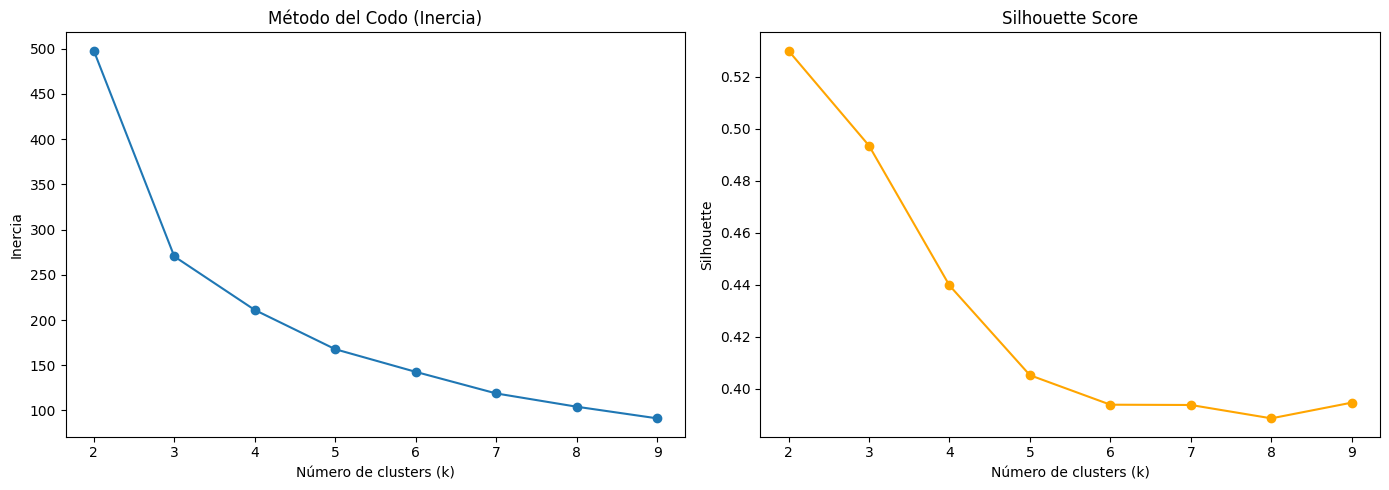

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(X_2d)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_2d, kmeans.labels_))

# Gráficos de evaluación
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("Método del Codo (Inercia)")
ax[0].set_xlabel("Número de clusters (k)")
ax[0].set_ylabel("Inercia")

# Silhouette
ax[1].plot(K_range, silhouette, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Número de clusters (k)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

- **Método del Codo**: La inercia decrece al aumentar k, pero el cambio más significativo parece estar en k = 3, lo cual sugiere que podría ser un buen número de clusters.

-  **Silhouette Score**: El valor también es más alto para k = 3, lo que confirma que 3 es una buena elección, ya que indica mejor separación entre clusters.

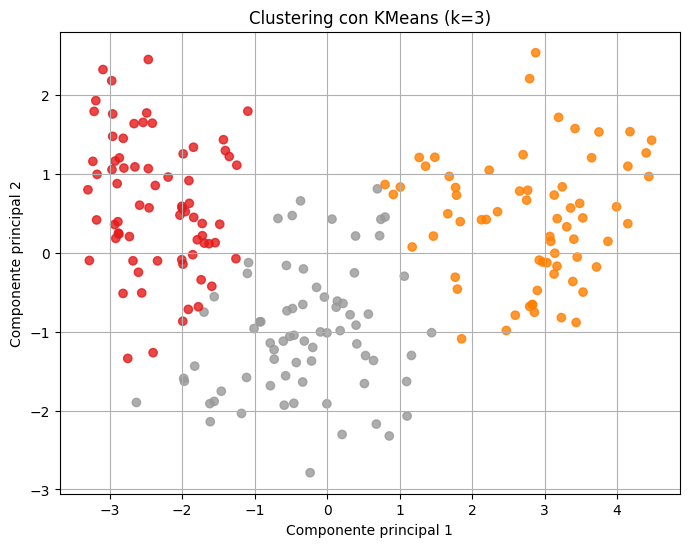

In [29]:
# Aplicar KMeans con k=3
kmeans_final = KMeans(n_clusters=3, n_init=25, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_2d)

# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
plt.title("Clustering con KMeans (k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

## Método Hierarchical Clustering / Dendrogramas

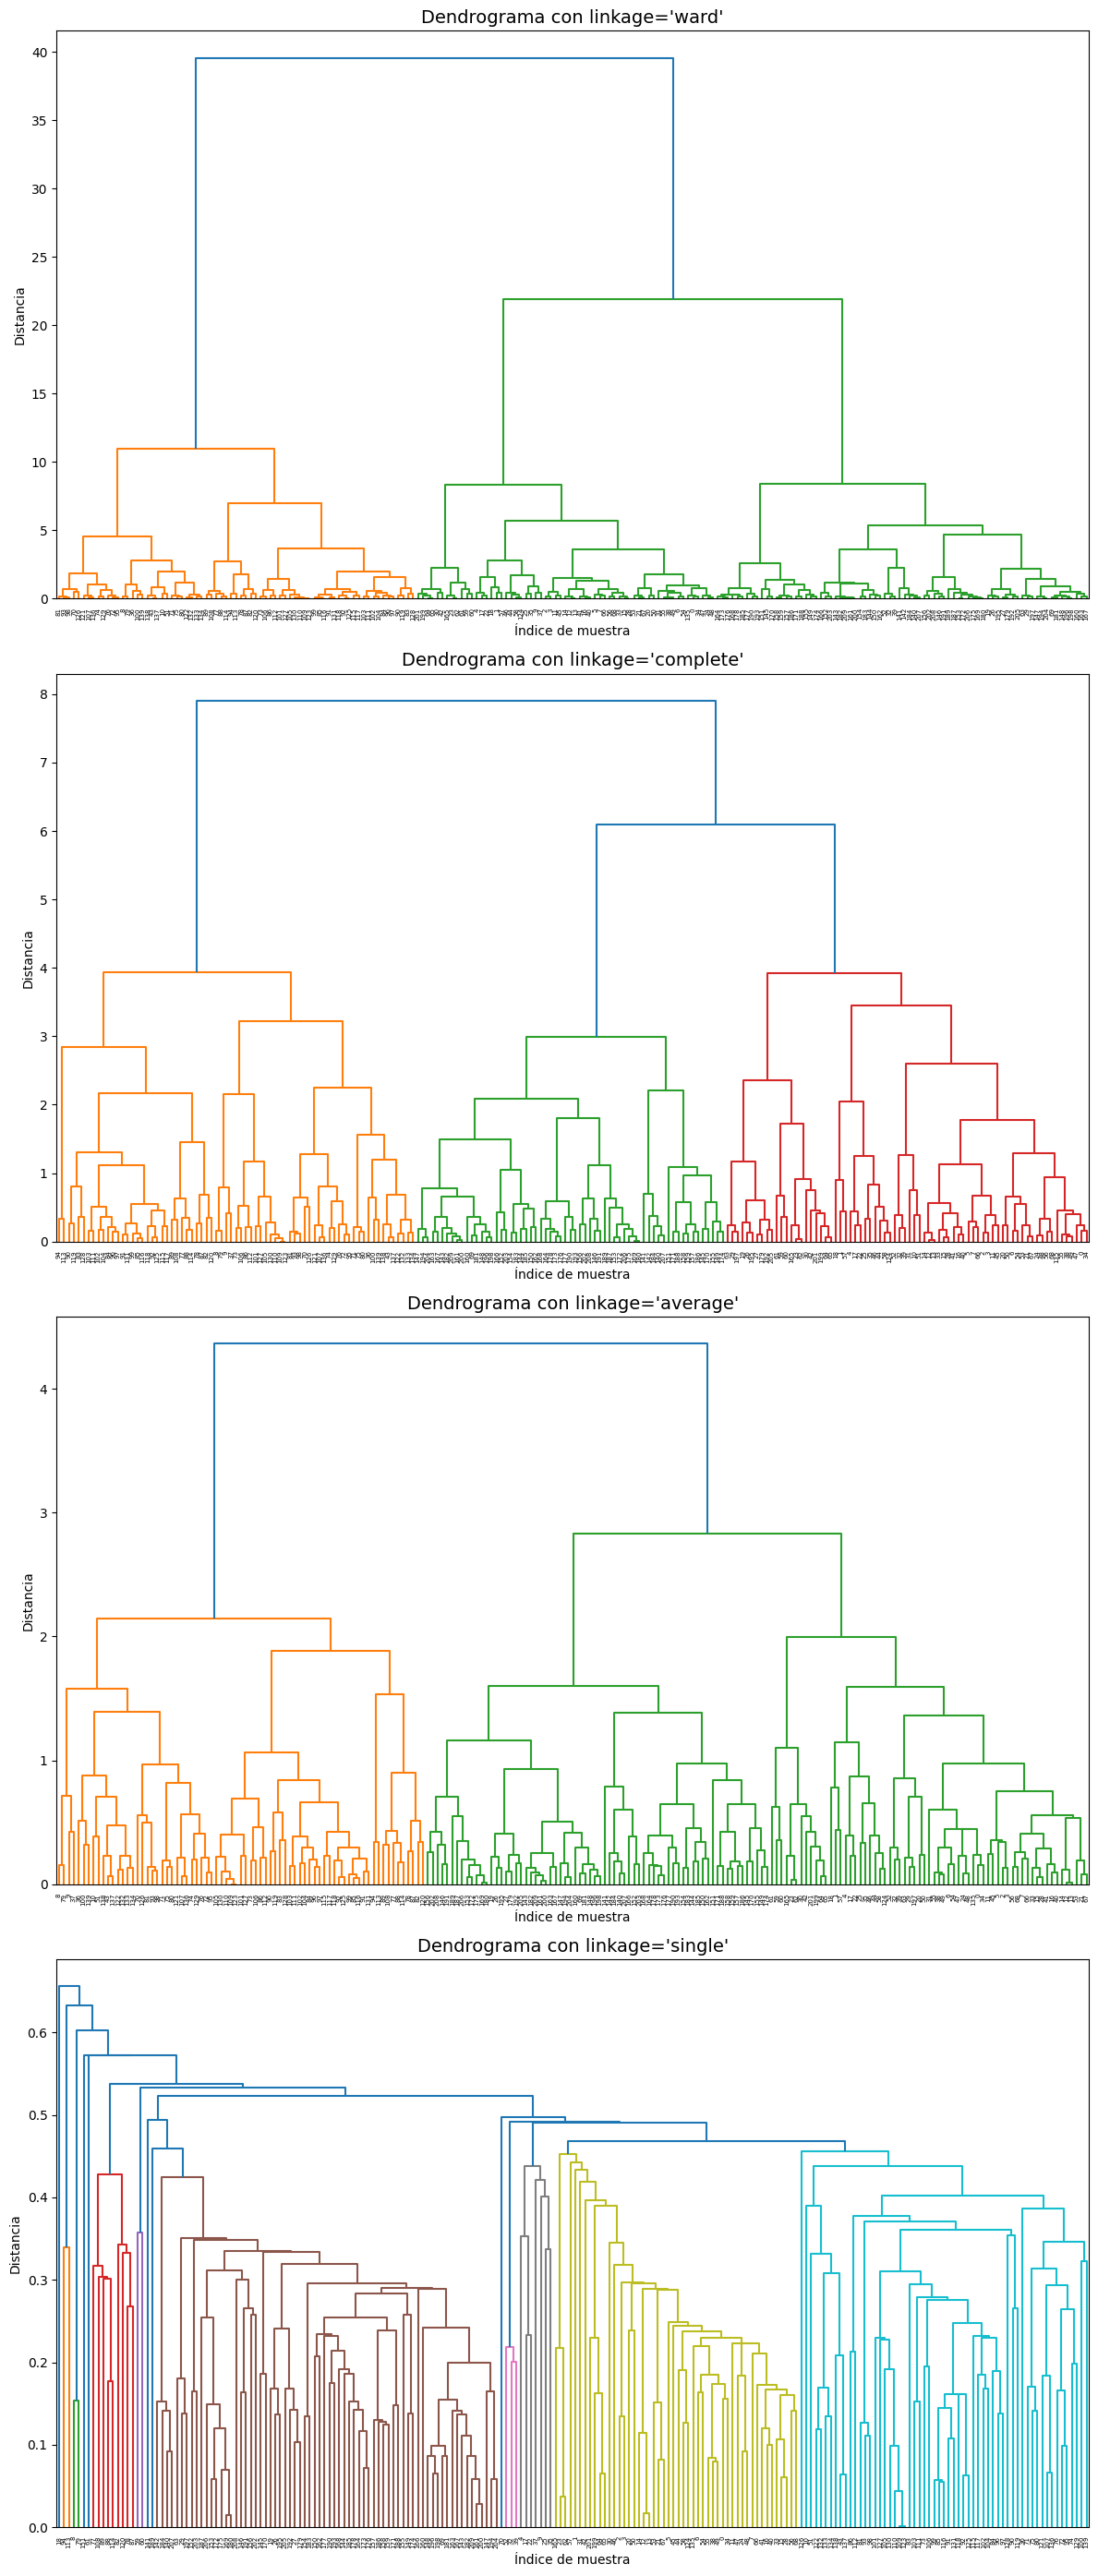

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Métodos de linkage a probar
linkage_methods = ["ward", "complete", "average", "single"]

# Dibujar un dendrograma para cada tipo de linkage
fig, axes = plt.subplots(len(linkage_methods), 1, figsize=(12, 28))

for ax, method in zip(axes, linkage_methods):
    Z = linkage(X_2d, method=method)
    dendrogram(Z, ax=ax)
    ax.set_title(f"Dendrograma con linkage='{method}'", fontsize=14)
    ax.set_xlabel("Índice de muestra")
    ax.set_ylabel("Distancia")

plt.tight_layout()
plt.show()

**ward**: muestra una separación muy clara en 3 grandes bloques, ideal para este problema. Es el más recomendado si trabajas con distancias euclídeas.

**complete** y **average**: también muestran una separación en 3 o 4 grupos razonables.

**single**: crea una estructura más encadenada (efecto cadena), lo que suele generar malos resultados en clustering — no es recomendable en este caso.

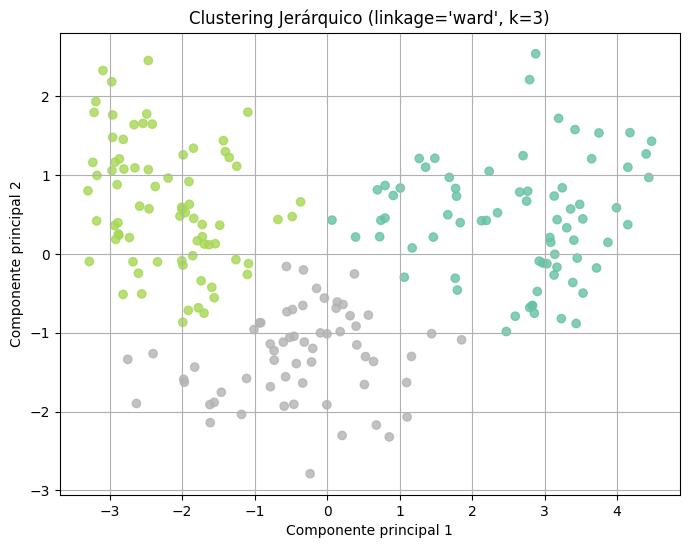

In [31]:
from sklearn.cluster import AgglomerativeClustering

# Aplicar clustering jerárquico con linkage 'ward' y 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo = agglo.fit_predict(X_2d)

# Visualizar los clusters jerárquicos
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
plt.title("Clustering Jerárquico (linkage='ward', k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


Este resultado del clustering jerárquico con ward y k=3 se ve muy limpio y estructurado:

    Los tres grupos están bien separados visualmente.

    No parece haber solapamientos importantes entre los clusters.

    Es un gran punto de comparación contra KMeans.

## Método DBSCAN

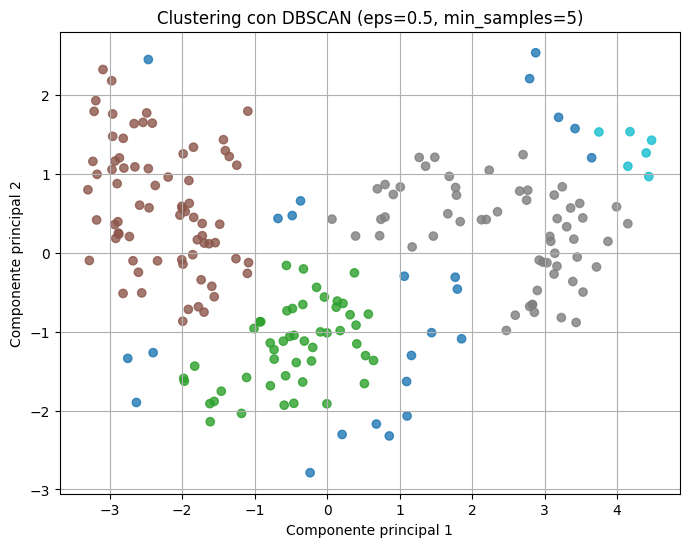

In [32]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN con valores iniciales
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.5, min_samples=5)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


DBSCAN ha identificado más de 3 clusters, y probablemente algunos puntos como ruido (label = -1), que aparecen con un color distinto o más tenue.
Algunos grupos están razonablemente bien formados, pero otros parecen fragmentados, lo que sugiere que los valores por defecto podrían no ser ideales.

Toca ajustar los hiperparámetros:
- eps (radio de vecindad): prueba valores entre 0.3 y 0.8.

- min_samples (mínimo de vecinos para formar un núcleo): normalmente entre 3 y 10.

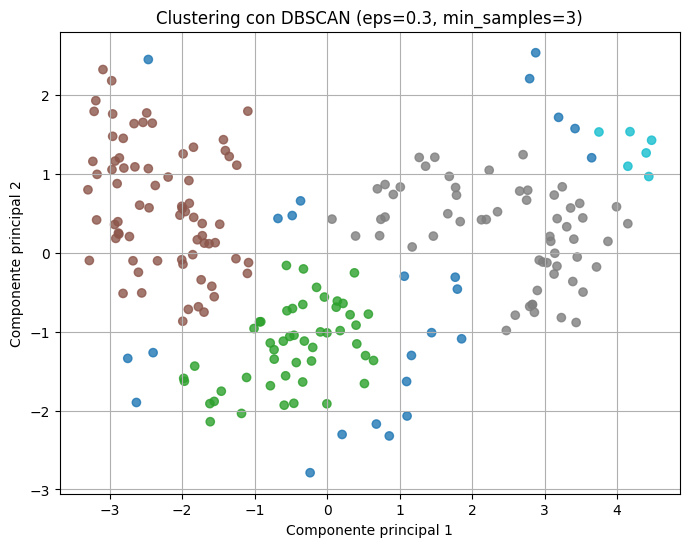

In [33]:
# Aplicar DBSCAN con valores iniciales
dbscan_min = DBSCAN(eps=0.3, min_samples=3)
labels_dbscan_min = dbscan_min.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.3, min_samples=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

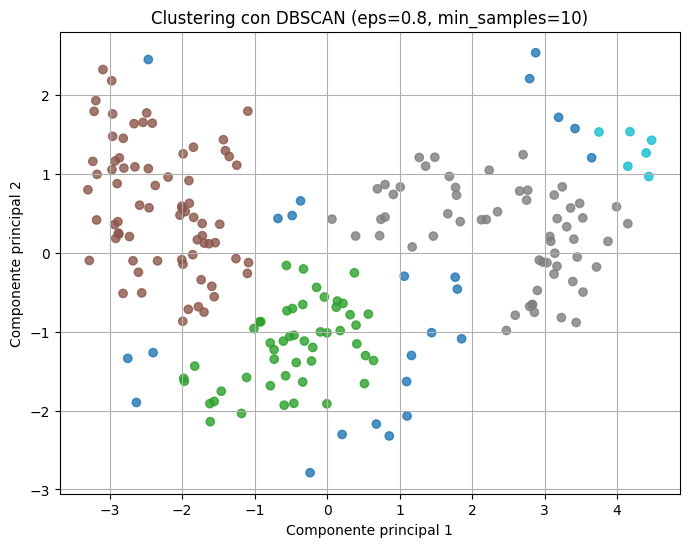

In [34]:
# Aplicar DBSCAN con valores iniciales
dbscan_max = DBSCAN(eps=0.8, min_samples=10)
labels_dbscan_max = dbscan_max.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.8, min_samples=10)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

### Comparativa de DBSCAN con distintas configuraciones

Se ha probado el algoritmo DBSCAN variando los hiperparámetros `eps` (radio de vecindad) y `min_samples` (mínimo de vecinos para formar un núcleo). A continuación se muestran los resultados:

#### 🔹 DBSCAN (eps = 0.5, min_samples = 5)
- Se identifican **3 grupos principales** que coinciden razonablemente con la estructura esperada.
- Algunos puntos aparecen como **ruido**, pero no de forma excesiva.
- Es una **configuración equilibrada**, capaz de captar la estructura sin sobresegmentar ni agrupar todo en uno solo.

#### 🔸 DBSCAN (eps = 0.3, min_samples = 3)
- Se generan **muchos clusters pequeños**, lo cual indica **overclustering**.
- El algoritmo es muy sensible a pequeñas variaciones, y muchos puntos son detectados como grupos independientes.
- No resulta útil para interpretar una estructura global.

#### 🔸 DBSCAN (eps = 0.8, min_samples = 10)
- Se obtiene un número elevado de clusters pequeños, muy parecido al caso anterior.
- Esta combinación parece **demasiado permisiva**, lo que lleva a fragmentar los datos.
- Se detectan también muchos valores atípicos.

---

**✅ Conclusión**: La combinación **`eps = 0.5`, `min_samples = 5`** es la más apropiada, ya que detecta 3 agrupaciones bien definidas y un número moderado de outliers. Esta configuración será la utilizada en el análisis final.


## 3. Análisis
###  ¿Cuál de los métodos de clustering captura mejor la estructura de clusters de este problema? 

Para realizar el análisis vamos a rehacer el código, asi evitamos una sobrecarga temporal del entorno, ya que el código es correcto y ya lo he ejecutado con éxito anteriormente.

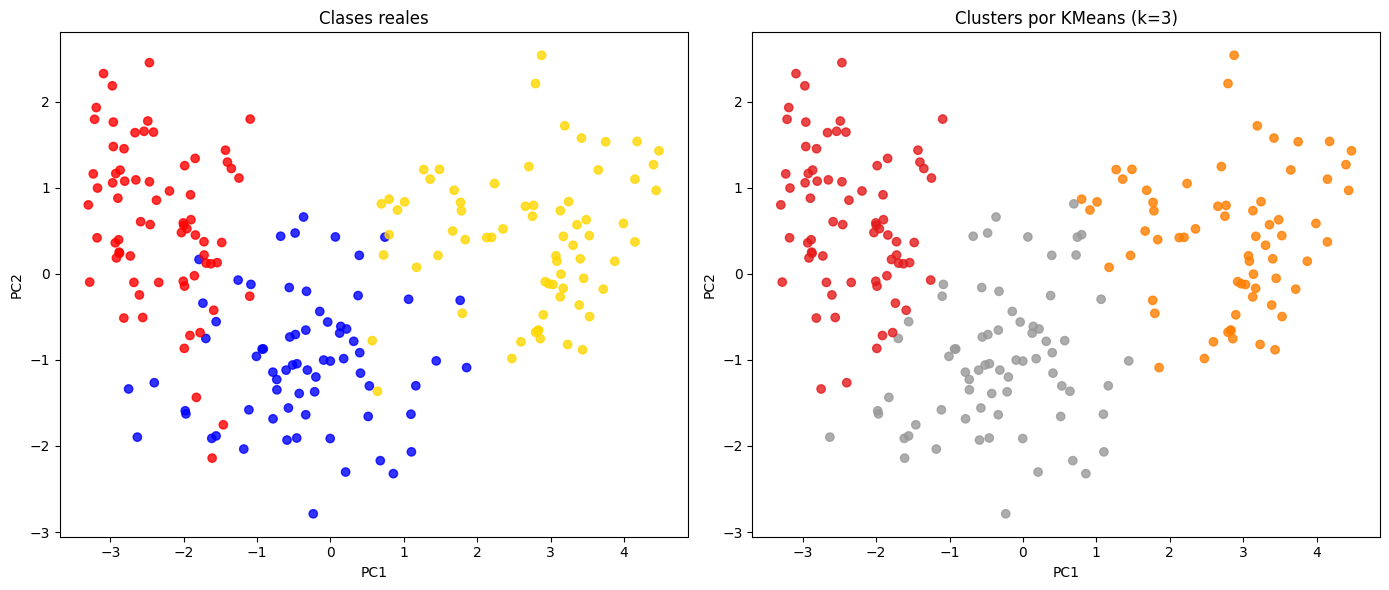

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]  # clase real

# Reducir a 2D con StandardScaler + PCA
X_scaled = StandardScaler().fit_transform(X)
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# KMeans clustering
labels_kmeans = KMeans(n_clusters=3, n_init=25, random_state=42).fit_predict(X_2d)

# Mapa de colores para clase real
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por KMeans
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
ax[1].set_title("Clusters por KMeans (k=3)")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


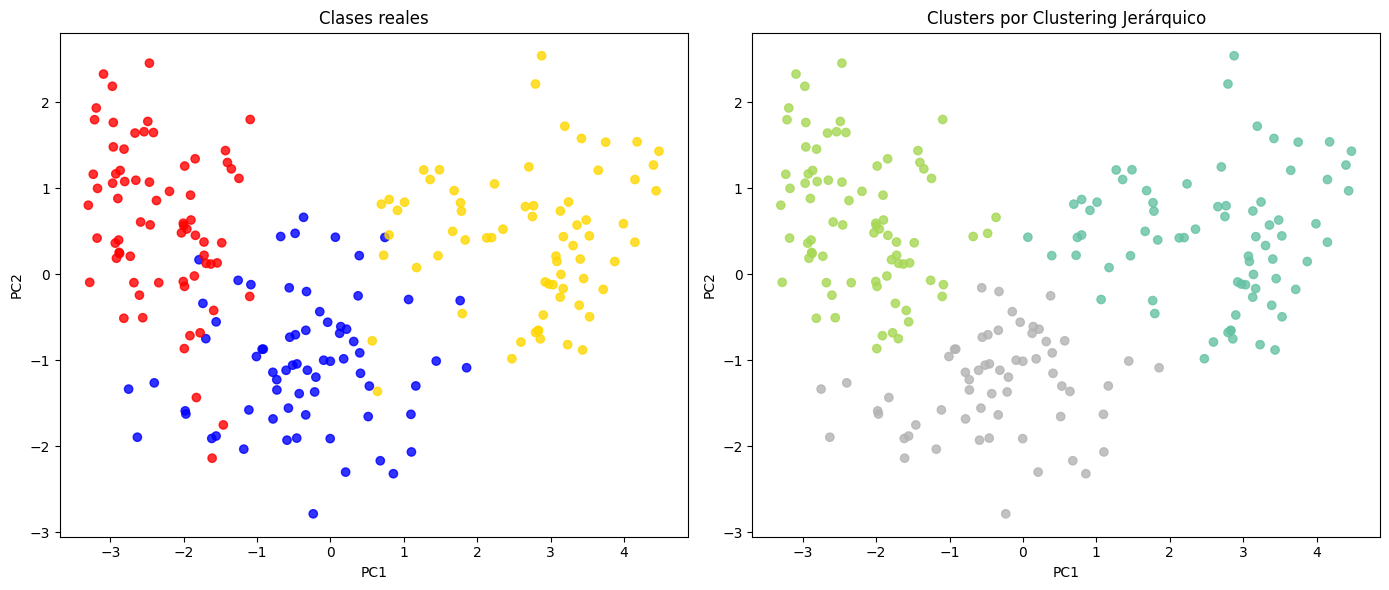

In [36]:
# Re-importar librerías y recargar datos tras el reset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Escalado + PCA
X_scaled = StandardScaler().fit_transform(X)
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# Colores por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Clustering jerárquico
labels_agglo = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_2d)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por jerárquico
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
ax[1].set_title("Clusters por Clustering Jerárquico")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


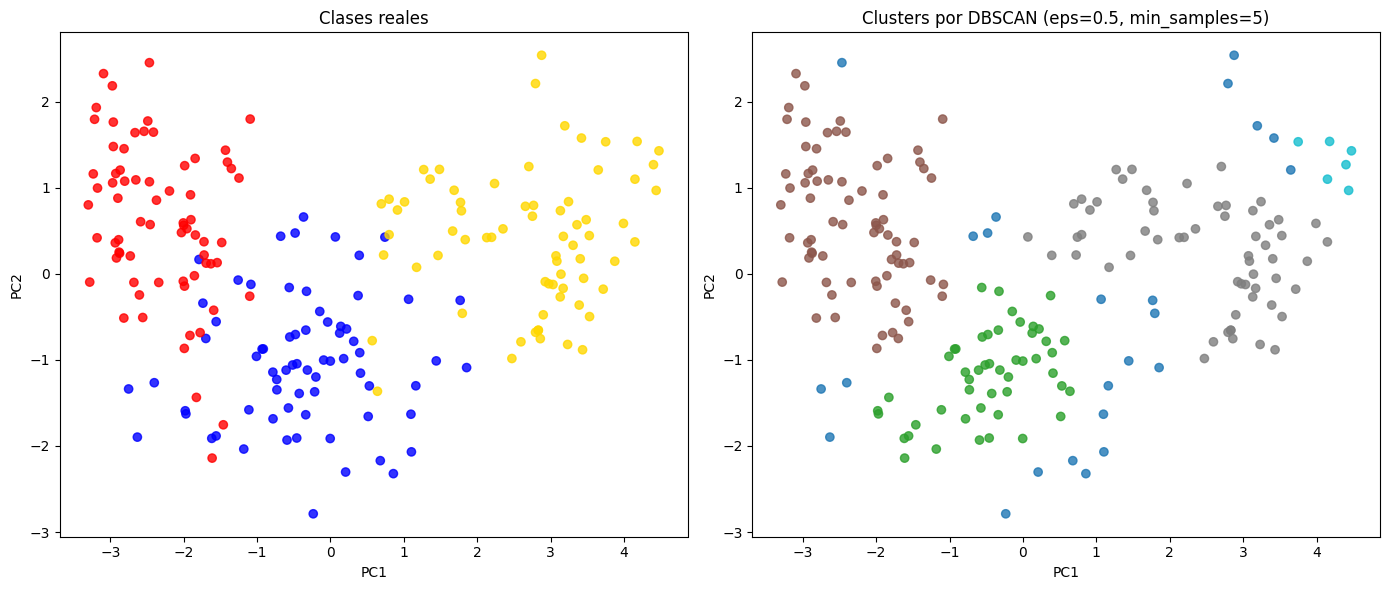

In [37]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Ejecutar DBSCAN con los parámetros elegidos
labels_dbscan = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_2d)

# Visualización comparativa
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Clases reales
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.8)
ax[0].set_title("Clases reales")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Clusters por DBSCAN
ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
ax[1].set_title("Clusters por DBSCAN (eps=0.5, min_samples=5)")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


### Comparación visual entre clustering y clases reales

Se muestran a continuación los resultados de los tres algoritmos de clustering aplicados a los datos reducidos con PCA (2 componentes), comparados con la distribución original de las clases reales.

#### 🔹 KMeans (`k=3`)
- Los grupos formados se corresponden **razonablemente bien con las clases reales**.
- La separación entre clusters es clara, especialmente en los extremos.
- Algunos puntos se encuentran mal clasificados, pero el patrón general es coherente.

#### 🔸 Clustering jerárquico (linkage = `ward`, `k=3`)
- **Resultado muy similar al de KMeans**, con fronteras bien definidas.
- Capta correctamente la estructura de los tres grupos principales.
- Ligero solapamiento en zonas intermedias, pero en general muy efectivo.

#### 🔸 DBSCAN (`eps = 0.5`, `min_samples = 5`)
- Identifica agrupaciones relevantes, pero **no se alinea tan bien con las clases reales**.
- Algunos puntos son marcados como **ruido (`-1`)**, lo que puede ser útil para detectar outliers.
- Es más sensible a la densidad de los datos que los métodos anteriores.

---

**✅ Conclusión visual**:  
Tanto **KMeans como el clustering jerárquico** ofrecen una buena aproximación a la distribución real de las clases. DBSCAN aporta valor al detectar puntos atípicos, pero no reproduce con tanta fidelidad la estructura de clases original.


### ¿Hay relación entre los clusters obtenidos y las clases de semillas originales? (variable de respuesta “clase”)
Para contestar esta pregunta, a parte de explicar visualmente si los clusters y las clases coinciden (Lo hice anteriormente) Tenemos que calcular una métrica de similitud entre etiquetas

In [38]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import pandas as pd

# Clustering
labels_kmeans = KMeans(n_clusters=3, n_init=25, random_state=42).fit_predict(X_2d)
labels_agglo = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_2d)
labels_dbscan = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_2d)

# Etiquetas reales
true_labels = df.iloc[:, -1]

# Métricas
ari_kmeans = adjusted_rand_score(true_labels, labels_kmeans)
ami_kmeans = adjusted_mutual_info_score(true_labels, labels_kmeans)

ari_agglo = adjusted_rand_score(true_labels, labels_agglo)
ami_agglo = adjusted_mutual_info_score(true_labels, labels_agglo)

ari_dbscan = adjusted_rand_score(true_labels, labels_dbscan)
ami_dbscan = adjusted_mutual_info_score(true_labels, labels_dbscan)

# Mostrar resultados en tabla
resultados = pd.DataFrame({
    "ARI": [ari_kmeans, ari_agglo, ari_dbscan],
    "AMI": [ami_kmeans, ami_agglo, ami_dbscan]
}, index=["KMeans", "Jerárquico", "DBSCAN"])

print(resultados)


                 ARI       AMI
KMeans      0.785036  0.736089
Jerárquico  0.753794  0.710466
DBSCAN      0.636568  0.605435


#### ✅ Conclusión:
Sí existe una relación significativa entre los clusters generados y las clases originales.  
Los mejores resultados se obtienen con **KMeans**, seguido de cerca por el método **jerárquico**.  
Ambos superan claramente a DBSCAN, que si bien captura estructura, no reproduce tan fielmente las clases reales.

### Boxplots

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir etiquetas de cluster de KMeans
df_clusters = df.copy()
df_clusters["Cluster_KMeans"] = labels_kmeans

# Obtener las variables numéricas originales
features = df.columns[:-1]

# Crear figura
fig, axes = plt.subplots(len(features), 1, figsize=(10, 4 * len(features)))

# Graficar un boxplot por variable
for i, feature in enumerate(features):
    sns.boxplot(x="Cluster_KMeans", y=feature, data=df_clusters, ax=axes[i])
    axes[i].set_title(f"Distribución de '{feature}' por cluster (KMeans)")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'seaborn'

### Interpretación de los clusters obtenidos con KMeans mediante boxplots

Para entender las características que definen cada grupo generado por KMeans, se han representado boxplots de las variables originales según el cluster asignado.

#### 🔍 Principales observaciones:

- **Área y Perímetro**: los clusters muestran diferencias claras. Un grupo tiene valores de área y perímetro notablemente mayores, lo que sugiere que esta dimensión es clave en la separación.
  
- **Longitud del eje mayor y menor**: también discriminan bien entre clusters. Los boxplots muestran cómo un grupo tiene ejes significativamente más largos.

- **Compacidad y simetría**: estas variables muestran una separación más sutil, pero siguen una tendencia que contribuye a la estructura de los grupos.

- **Longitud del surco**: es una de las variables más útiles para diferenciar los clusters, ya que presenta medianas claramente distintas en los tres grupos.

---

### ✅ Conclusión:
Los clusters generados por KMeans no solo reflejan bien la estructura de clases, sino que además permiten identificar qué variables (como área, perímetro, eje mayor y longitud del surco) son **más relevantes para caracterizar los distintos tipos de semillas**.
